In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS, EXAMPLE_FILES_from_LOCATIONS, EXAMPLE_FILES_to_FILEPATHS, EXAMPLE_FILES_to_DETECTIONS
import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh

from cli import get_file_paths

In [4]:
site_key = 'Central'
freq_key = 'HF2'

bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 2000
print(f'Looking at {fig_details["site_name"]}')

Looking at Central Pond


In [5]:
filepath_key = EXAMPLE_FILES_from_LOCATIONS[bout_params['site_key']][5]
filename = filepath_key.split('/')[-1]

file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 660
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 50 # hide anything below -rm_dB dB

data_params = dict()
data_params['site_tag'] = bout_params['site_key']
data_params['type_tag'] = ''
data_params['cur_dc_tag'] = '1800of1800'

file_paths = get_file_paths(data_params)

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['ylim'] = 96000
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

In [6]:
csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['cur_dc_tag'])
bout_params = bt_clustering.get_bout_params_from_location(dh.assemble_initial_location_summary(data_params, file_paths), data_params)
batdetect2_preds_with_bouttags = bt_clustering.classify_bouts_in_bd2_predictions_for_freqgroups(batdetect2_predictions, bout_params)
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
bout_metrics = bt_clustering.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

In [7]:
def plot_audio_seg(audio_features, spec_features):
    """
    Function to plot the spectrogram of a provided audio segment
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size' : 24})
    plt.title(f"Spectrogram representation of {audio_features['file_path'].name}", fontsize=22)
    plt.rcParams.update({'font.size': 24})
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.ylim(0, (spec_features['ylim'])/(fs/2))
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()

def plot_dets_over_audio_seg(audio_features, spec_features, plot_dets):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.rcParams.update({'font.size': 24})
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.ylim(0, (spec_features['ylim'])/(fs/2))
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)**0.5), loc='upper right')

    plt.tight_layout()
    plt.show()

def plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections and bout tags for bout starts and ends.
    If there is a duty-cycle scheme being applied, also plots the recording windows being simulated.
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.title(f"BatDetect2 detections for simulated recording period on {audio_features['file_path'].name}", fontsize=22)
    plt.rcParams.update({'font.size': 24})
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    pink_patch = patches.Patch(facecolor='pink', edgecolor='k', label='Bout START/END')
    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [pink_patch, yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        if row['call_status'] != 'within bout' and row['call_status'] != 'outside bout':
            rect = patches.Rectangle(((row['start_time'] - start - 0.01)*(fs/2), (row['low_freq']-2000)/(fs/2)), 
                        0.04*(fs/2), 12000/(fs/2), linewidth=4, edgecolor='pink', facecolor='none', alpha=0.8)
        else:
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)

    dc_tag = data_params['cur_dc_tag']
    cycle_length = int(dc_tag.split('of')[1])
    time_on = int(dc_tag.split('of')[0])

    window_starts = np.arange(0, 1800, cycle_length)
    for window_start in window_starts:
        if (window_start <= start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.3)
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.3)
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=0.3)
            ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.ylim(0, (spec_features['ylim'])/(fs/2))
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)**0.5), loc='upper right')

    plt.tight_layout()
    plt.show()

def plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed bouts and bout duurations.
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.title(f"BCI-derived bouts using BD2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.rcParams.update({'font.size': 24})
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label=f'BCI = {round(bout_params["HF2_bci"], 2)}ms')
    red_patch = patches.Patch(facecolor='red', edgecolor='k', label=f'BCI = {round(bout_params["HF1_bci"], 2)}ms')
    blue_patch = patches.Patch(facecolor='cyan', edgecolor='k', label=f'BCI = {round(bout_params["LF1_bci"], 2)}ms')

    legend_patches = [blue_patch, red_patch, yellow_patch]
    ax = plt.gca()
    for i, row in plot_bouts.iterrows():
        plt.text(x=(row['start_time'] - start + (row['bout_duration_in_secs']/5))*(fs/2), y=min((row['high_freq']+2000)/(fs/2), 3/4), 
                            s=f"{round(row['bout_duration_in_secs'], 2)}s", color='pink', fontsize=14)
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['bout_duration_in_secs'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor=FREQUENCY_COLOR_MAPPINGS[row['freq_group']], facecolor='none', alpha=0.8)
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.ylim(0, (spec_features['ylim'])/(fs/2))
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)), loc='upper right')

    plt.tight_layout()
    plt.show()

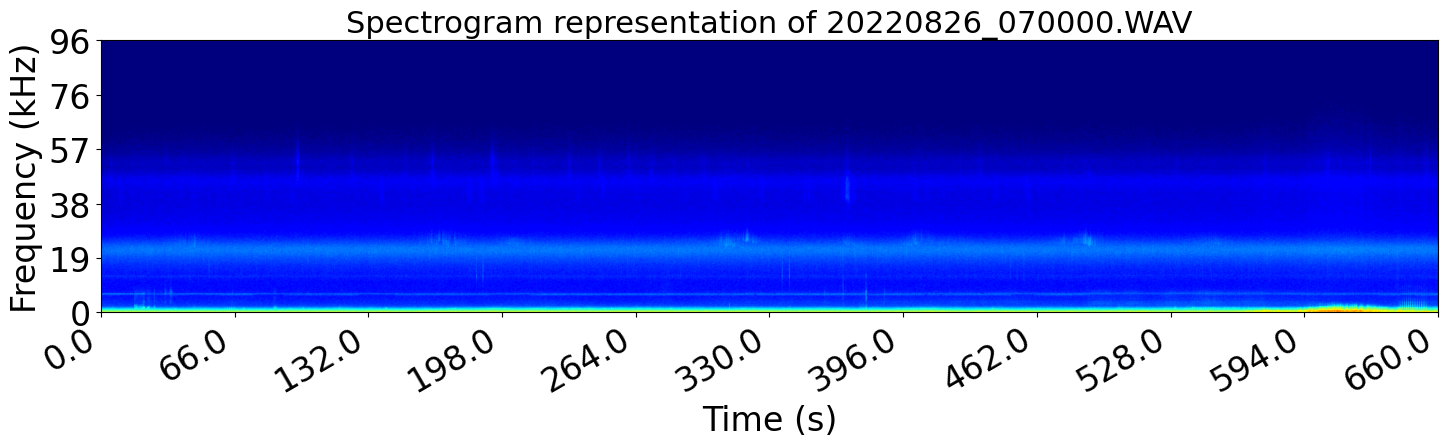

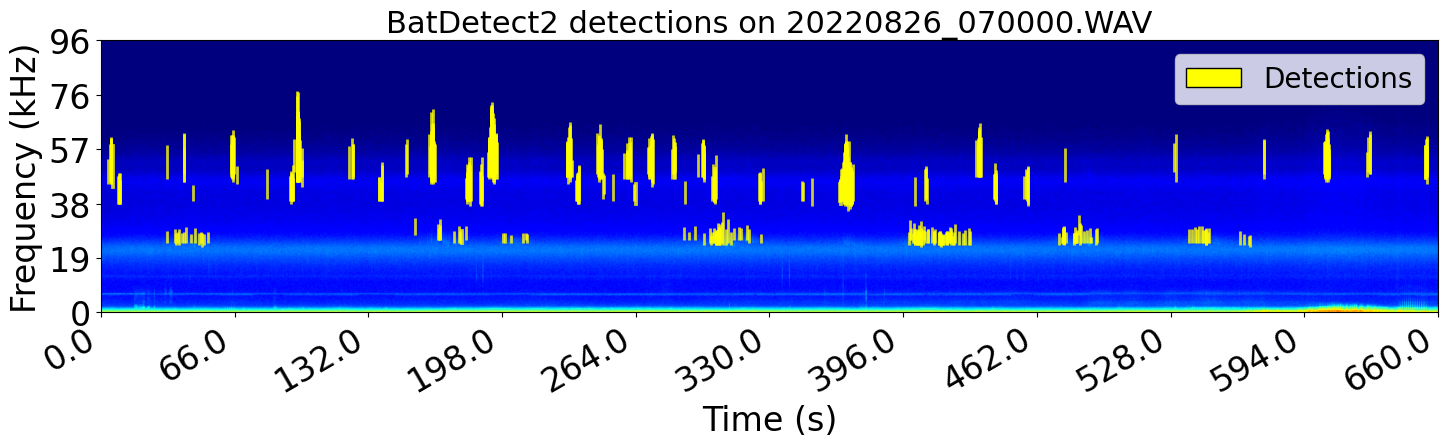

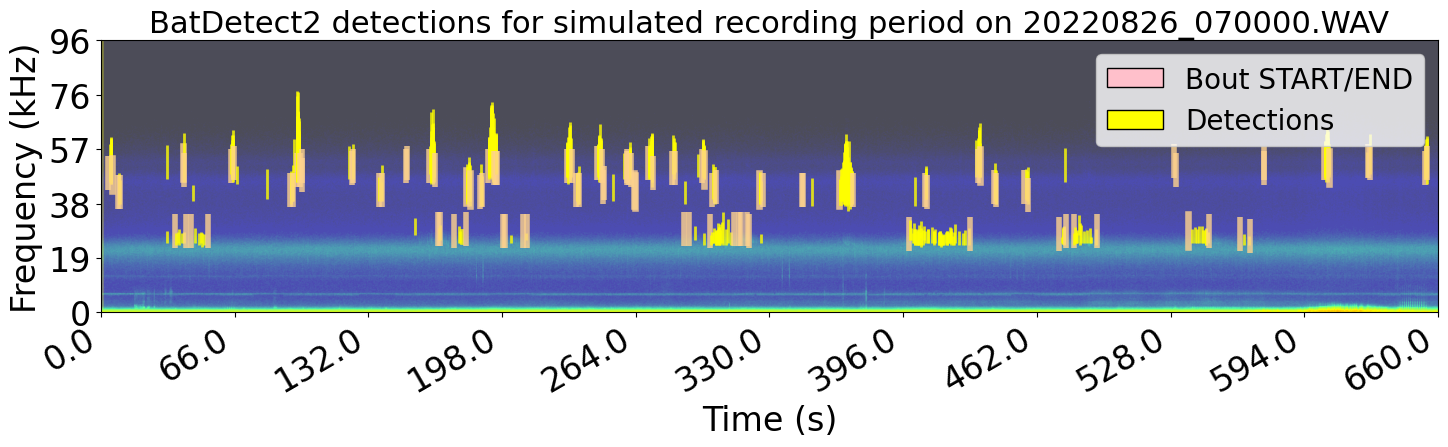

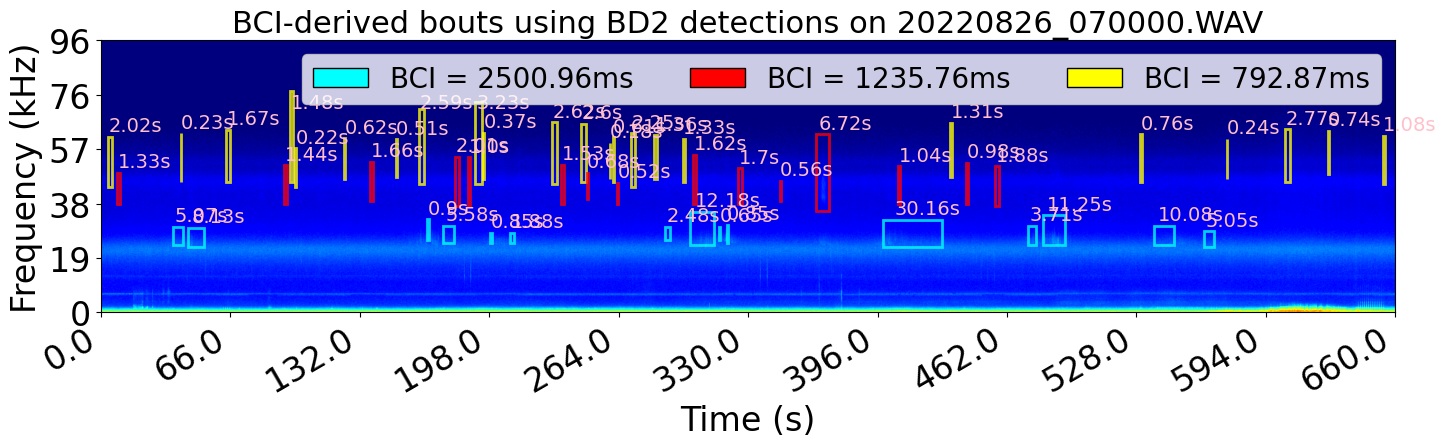

In [8]:
plot_audio_seg(audio_features, spec_features)
plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

In [117]:
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 460
duration = 60
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 45 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['ylim'] = 54000
spec_features['vmin'] = vmin
spec_features['NFFT'] = 2048
spec_features['cmap'] = 'jet'

plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

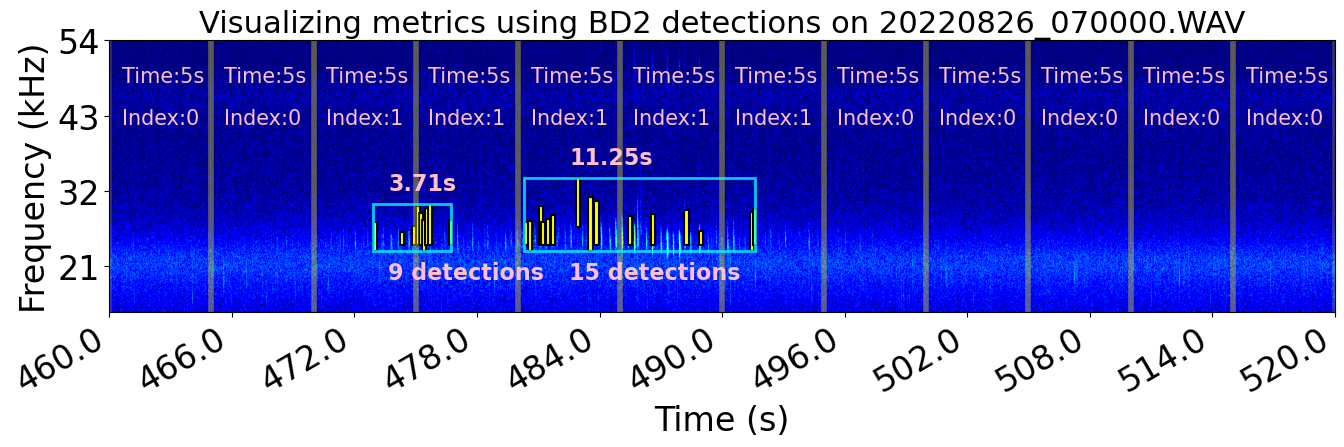

In [137]:
audio_seg = audio_features['audio_seg']
fs = audio_features['sample_rate']
start = audio_features['start']
duration = audio_features['duration']

plt.figure(figsize=(14, 5))
plt.title(f"Visualizing metrics using BD2 detections on {audio_features['file_path'].name}", fontsize=22)
plt.rcParams.update({'font.size': 24})
plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

ax = plt.gca()
for i, row in plot_dets.iterrows():
    # if row['call_status'] != 'within bout' and row['call_status'] != 'outside bout':
    #     rect = patches.Rectangle(((row['start_time'] - start - 0.01)*(fs/2), (row['low_freq']-2000)/(fs/2)), 
    #                 0.04*(fs/2), 12000/(fs/2), linewidth=4, edgecolor='pink', facecolor='none', alpha=0.8)
    #     ax.add_patch(rect)
    # else:
    if row['high_freq']<=spec_features['ylim']:
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (0.2)*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=1.5, edgecolor='k', facecolor='yellow', alpha=1)
        ax.add_patch(rect)

cycle_length = 5
time_on = cycle_length

window_starts = np.arange(0, 1800, cycle_length)
for window_start in window_starts:
    if (window_start < start+duration and window_start+time_on > start):
        calls_in_block = len(plot_dets.loc[(plot_dets['start_time']>=window_start)&(plot_dets['end_time']<=(window_start+time_on))]) > 0
        if calls_in_block:
            label = 'Index:1'
        else:
            label = 'Index:0'
        plt.text(x=((window_start - start + ((time_on**2)/40)))*(fs/2), y=min((42000)/(fs/2), 3/4), 
                    s=label, color='pink', fontsize=min(16, 10+cycle_length))
        plt.text(x=((window_start - start + ((time_on**2)/40)))*(fs/2), y=min((48000)/(fs/2), 3/4), 
                    s=f"Time:{time_on}s", color='pink', fontsize=min(16, 10+cycle_length))
        if (window_start <= start):
            rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                    linewidth=4, edgecolor='yellow', facecolor='none', alpha=0.2)
        elif (window_start+time_on) >= (start+duration):
            rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                    (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                    linewidth=4, edgecolor='yellow', facecolor='none', alpha=0.2)
        else:
            rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (time_on)*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='none', alpha=0.2)
        ax.add_patch(rect)

ax = plt.gca()
for i, row in plot_bouts.iterrows():
    if (row['high_freq']+6000)<=spec_features['ylim']:
        plt.text(x=(row['start_time'] - start + (row['bout_duration_in_secs']/5))*(fs/2), y=min((row['high_freq']+2000)/(fs/2), 3/4), 
                            s=f"{round(row['bout_duration_in_secs'], 2)}s", color='pink', fontsize=16, weight='bold')
        plt.text(x=(row['start_time'] - start + (row['bout_duration_in_secs']/5))*(fs/2), y=min((row['low_freq']-4000)/(fs/2), 3/4), 
                            s=f"{row['number_of_dets']} detections", color='pink', fontsize=16, weight='bold')
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['bout_duration_in_secs']+0.1)*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor=FREQUENCY_COLOR_MAPPINGS[row['freq_group']], facecolor='none', alpha=0.8)
        ax.add_patch(rect)

plt.yticks(ticks=np.linspace(0, spec_features['ylim']/(fs/2), 6), labels=np.linspace(0, spec_features['ylim']/1000, 6).astype('int'))
plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (s)")
plt.ylim(15000/(fs/2), spec_features['ylim']/(fs/2))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()